In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xlrd
girl, boy = np.loadtxt(fname='girl.txt'),np.loadtxt('boy.txt')
girlY, boyY =np.ones(girl.shape[0]), np.zeros(165)
X, Y = np.vstack((boy, girl)), np.hstack((boyY, girlY))
sheet = xlrd.open_workbook("fm_2018.xlsx").sheets()[0]
X1,X2,X3= sheet.col_values(0),sheet.col_values(1),sheet.col_values(2)
X_test = np.array([X1,X2,X3]).T
X_test, y_test = X_test[1:,:], np.array(sheet.col_values(3))[1:]
y_test = np.array(y_test=="女",dtype="float64")
X_test, Y = X_test.astype("float64"), Y.astype('float64')

R_squre
[0.15270935960591125, 0.3645320197044335, 0.4704433497536945, 0.3645320197044335]
accuracy
[0.813953488372093, 0.8604651162790697, 0.8837209302325582, 0.8604651162790697]
R_squre
[0.7881773399014778, 0.8940886699507389, 0.7881773399014778, 0.6822660098522167]
accuracy
[0.9534883720930233, 0.9767441860465116, 0.9534883720930233, 0.9302325581395349]
R_squre
[0.7881773399014778, 0.7881773399014778, 0.7881773399014778, 0.4704433497536945]
accuracy
[0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.8837209302325582]


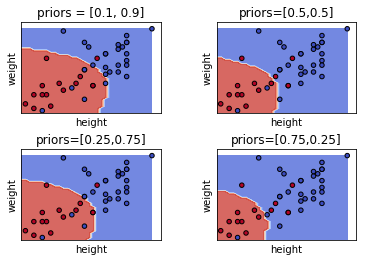

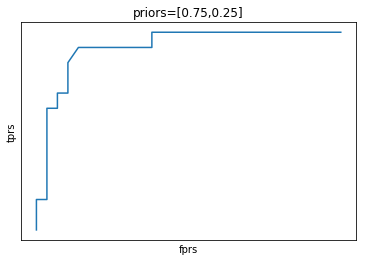

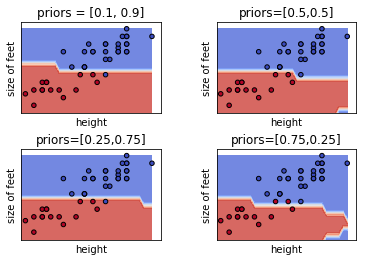

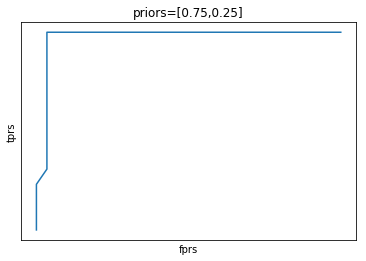

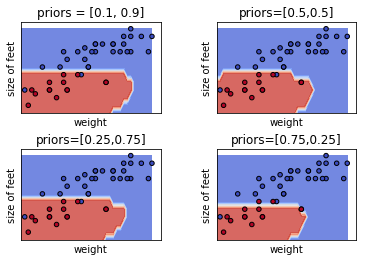

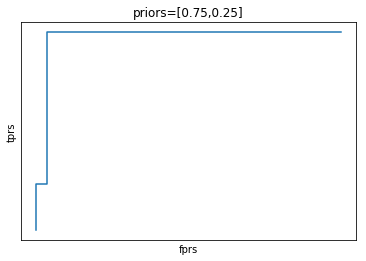

In [23]:
bayers_2d(0,1)
bayers_2d(0,2)
bayers_2d(1,2)

In [32]:
def bayers_2d(i, j):    
    models = (BayersGN(priors = [0.1, 0.9]),
               BayersGN(priors=[0.5,0.5]),
               BayersGN(priors=[0.25,0.75]),
               BayersGN(priors=[0.75,0.25])) 
    X_2d = np.vstack((X[:,i],X[:,j])).T
    X_test_2d = np.vstack((X_test[:,i],X_test[:,j])).T
    models = [clf.fit(X_2d, Y) for clf in models]
    # scores
    scores = [model.score(X_test_2d, y_test) for model in models]
    print("R_squre")
    print(scores)
    s = [sum(model.predict(X_test_2d)==y_test)/len(y_test) for model in models]
    print("accuracy")
    print(s)
    # title for the plots
    titles = ('priors = [0.1, 0.9]',
              'priors=[0.5,0.5]',
              'priors=[0.25,0.75]',
              'priors=[0.75,0.25]')
    labels = ("height","weight","size of feet")
    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    from playML.metrics import plot_decision_boundary
    for clf, title, ax in zip(models, titles, sub.flatten()):
        plot_decision_boundary(ax, clf, X_test_2d, h=1)
        ax.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')  
        ax.set_xlabel(labels[i])
        ax.set_ylabel(labels[j])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
    
    
    fig, sub = plt.subplots(1, 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    from playML.metrics import roc
    from sklearn.metrics import roc_curve
    fprs = []
    tprs = []
    decision_scores = clf.decision_function(X_test_2d)
    fprs, tprs,_  = roc(decision_scores, y_test)
#     fprs, tprs,_  = roc_curve(y_test,decision_scores )
    sub.plot(fprs, tprs)
    sub.set_xlabel("fprs")
    sub.set_ylabel("tprs")
    sub.set_ylim((0,1))
    sub.set_xlim((0,1))
    sub.set_xticks(())
    sub.set_yticks(())
    sub.set_title(title)

In [10]:
import numpy as np
from numpy.linalg import inv

from playML.metrics import r2_score


class BayersGN:
    def __init__(self, priors=[0.5, 0.5]):
        """初始化Linear Regression模型"""
        self.priors = priors
        self._mean = None
        self._cov = None

    def fit(self, X_train, y_train):
        """
        sorted_y 和priors对应的类别序号相对应
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        sorted_y = np.sort(np.unique(y_train))
        self._mean = np.array([X_train[y_train == y].mean(axis=0) for y in sorted_y])
        self._cov = np.array([np.cov(X_train[y_train == y].T) for y in sorted_y])
        return self

    def predict(self, X_predict):
        """给定带预测数据集X_predict,返回表示X_predict的结果向量"""
        y_predict = [self._predict(x) for x in X_predict]
        return np.array(y_predict)

    def _predict(self, Xi):
        return np.argsort(self._rvs_g(Xi))[0]

    def decision_function(self, X_test):
        b=[]
        for i in range(len(X_test)):
            g = self._rvs_g(X_test[i])
            b.append(g[0]-g[1])
        return b

    def score(self, X_test, y_test):
        """根据数据集X_test，y_test计算准确度 默认为r2_score"""
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)

    def _rvs_g(self, Xi):
        if len(self._cov.shape) == 1:
            rvs_g = [(Xi - self._mean[i]) / self._cov[i] + np.log(self._cov[i]) - 2 * np.log(self.priors[i]) for i in
                     range(len(self._mean))]
        else:
            rvs_g = [np.matmul(np.matmul((Xi - self._mean[i]), inv(self._cov[i])),
                               (Xi - self._mean[i])) +
                     np.log(np.linalg.det(self._cov[i])) - 2 * np.log(self.priors[i]) for i in range(len(self._mean))]
        return rvs_g
    